# **SSCS - Test Playground**

Developed by André Paiva

Based on SSCS Dataset created by Helena Cuesta and Emilia Gómez

**INSTRUCTIONS OF USE:**

Before you run this notebook, please follow the instructions:

1.  Create a new folder "Datasets" in the same directory of this notebook.
2.  Download the `SSCS_HDF5` dataset on [this link](https://ufbabr-my.sharepoint.com/personal/andre_paiva_ufba_br/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fandre_paiva_ufba_br%2FDocuments%2FDatasets%2FSSCS_HDF5%2Ezip&parent=%2Fpersonal%2Fandre_paiva_ufba_br%2FDocuments%2FDatasets&ga=1) and move it to "Datasets" folder.
3.  If you're running this notebook on Google Colab, please **uncomment the following cell** and **change `EXECUTE_ON_COLAB` to `True`.**

In [1]:
'''
%pip --quiet install ray

import os
import shutil

from google.colab import drive
drive.mount('/content/gdrive')

drive_src = '/content/gdrive/My Drive/UFBA/TCC/Datasets/SSCS_HDF5.zip'
colab_dst = '/content/Datasets/'

os.mkdir(colab_dst)
shutil.copy(drive_src, colab_dst)
'''

EXECUTE_ON_COLAB = False

## 1 - Import modules

In [2]:
import os
import json
import zipfile
import requests
import psutil

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy, Precision
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization

In [5]:
num_threads = 3
os.environ["OMP_NUM_THREADS"] = str(num_threads)
os.environ["TF_NUM_INTRAOP_THREADS"] = str(num_threads)
os.environ["TF_NUM_INTEROP_THREADS"] = str(num_threads)

tf.config.threading.set_inter_op_parallelism_threads(num_threads)
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.set_soft_device_placement(True)

In [6]:
import ray

num_cpus = psutil.cpu_count(logical=False)
ray.init(num_cpus=num_cpus, ignore_reinit_error=True)

2023-06-05 05:45:20,932	INFO worker.py:1625 -- Started a local Ray instance.


Python version:,3.10.11
Ray version:,2.4.0


## 2 - Neural Network Model (VoasCNN)

In [7]:
SAVE_MODEL = True
LOAD_MODEL = True
SPLIT_SIZE = 128

In [8]:
def voas_cnn_model():
    x_in = Input(shape=(360, SPLIT_SIZE, 1))
    
    x = BatchNormalization()(x_in)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv1")(x)

    x = BatchNormalization()(x)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv2")(x)

    x = BatchNormalization()(x)

    x = Conv2D(filters=16, kernel_size=(70, 3), padding="same",
        activation="relu", name="conv_harm_1")(x)

    x = BatchNormalization()(x)

    x = Conv2D(filters=16, kernel_size=(70, 3), padding="same",
        activation="relu", name="conv_harm_2")(x)

    ## start four branches now

    x = BatchNormalization()(x)

    ## branch 1
    x1a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv1a")(x)

    x1a = BatchNormalization()(x1a)

    x1b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv1b")(x1a)

    ## branch 2
    x2a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv2a")(x)

    x2a = BatchNormalization()(x2a)

    x2b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv2b")(x2a)

    ## branch 3

    x3a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv3a")(x)

    x3a = BatchNormalization()(x3a)

    x3b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv3b")(x3a)

    x4a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv4a")(x)

    x4a = BatchNormalization()(x4a)

    x4b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv4b"
    )(x4a)


    y1 = Conv2D(filters=1, kernel_size=1, name='conv_soprano',
                padding='same', activation='sigmoid')(x1b)
    y1 = tf.squeeze(y1, axis=-1)
    y2 = Conv2D(filters=1, kernel_size=1, name='conv_alto',
                padding='same', activation='sigmoid')(x2b)
    y2 = tf.squeeze(y2, axis=-1)
    y3 = Conv2D(filters=1, kernel_size=1, name='conv_tenor',
                padding='same', activation='sigmoid')(x3b)
    y3 = tf.squeeze(y3, axis=-1)
    y4 = Conv2D(filters=1, kernel_size=1, name='conv_bass',
                padding='same', activation='sigmoid')(x4b)
    y4 = tf.squeeze(y4, axis=-1)

    out = [y1, y2, y3, y4]

    model = Model(inputs=x_in, outputs=out, name='voasCNN')

    return model

## 3 - Auxiliar functions and Variables

Functions designed to manipulate the SSCS dataset.

### 3.1 - File path variables

In [9]:
if(EXECUTE_ON_COLAB):
    dataset_dir = "/content/Datasets/"
else:
    dataset_dir = "Datasets/"
zipname = dataset_dir + "SSCS_HDF5.zip"
sscs_dir = dataset_dir + "SSCS_HDF5/"

songs_dir = sscs_dir + "sscs/"
splitname = sscs_dir + "sscs_splits.json"

### 3.2 - Download/Extract Scripts

In [10]:
# Download function deactivated. Please download dataset
# manually and use sscs_extract

'''
def download(url, fname):
    
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    downloaded_size = 0
    with open(fname, 'wb') as file:
        for data in resp.iter_content(chunk_size=max(4096, int(total/10000))):
            size = file.write(data)
            downloaded_size += size
            percent = min(downloaded_size/total, 1.0)
            print(f"\r{percent:.2%} downloaded", end='')
            
    print()
'''

'\ndef download(url, fname):\n    \n    resp = requests.get(url, stream=True)\n    total = int(resp.headers.get(\'content-length\', 0))\n    downloaded_size = 0\n    with open(fname, \'wb\') as file:\n        for data in resp.iter_content(chunk_size=max(4096, int(total/10000))):\n            size = file.write(data)\n            downloaded_size += size\n            percent = min(downloaded_size/total, 1.0)\n            print(f"\r{percent:.2%} downloaded", end=\'\')\n            \n    print()\n'

In [11]:
# Download function deactivated. Please download dataset
# manually and use sscs_extract

'''
def sscs_download():
    
    if(not os.path.exists(dataset_dir)):
        os.mkdir(dataset_dir)
   
    if(not os.path.exists(zipname)):
        print("Downloading SSCS Dataset...")
        url = "https://ufbabr-my.sharepoint.com/:u:/g/personal/andre_paiva_ufba_br/EaxMspG8b1BNmOuK&download=1"
        #url = create_onedrive_directdownload(url)
        download(url, zipname)
    else:
        print("SSCS Dataset found.")

    print("Done.")
'''

'\ndef sscs_download():\n    \n    if(not os.path.exists(dataset_dir)):\n        os.mkdir(dataset_dir)\n   \n    if(not os.path.exists(zipname)):\n        print("Downloading SSCS Dataset...")\n        url = "https://ufbabr-my.sharepoint.com/:u:/g/personal/andre_paiva_ufba_br/EaxMspG8b1BNmOuK&download=1"\n        #url = create_onedrive_directdownload(url)\n        download(url, zipname)\n    else:\n        print("SSCS Dataset found.")\n\n    print("Done.")\n'

In [12]:
def sscs_extract():
    with zipfile.ZipFile(zipname) as zf:
        if(not os.path.exists(sscs_dir)):
            os.mkdir(sscs_dir)
            zf.extractall(path=sscs_dir)
    print("SSCS Dataset Extracted.")

### 3.3 - Splits, songnames and songlists

In [13]:
def sscs_get_split(split='train'):
    
    if(split.lower() == 'train' or split.lower() == 'validate' or
       split.lower() == 'test'):
        return json.load(open(splitname, 'r'))[split.lower()]
    else:
        raise NameError("Split should be 'train', 'validate' or 'test'.")

In [14]:
def sscs_pick_songlist(first=0, amount=5, split='train'):
    
    songnames = sscs_get_split(split)
    return songnames[first:first+amount]

In [15]:
def sscs_pick_random_song(split='train'):
    
    songnames = sscs_get_split(split)
    rng = np.random.randint(0, len(songnames))
    return songnames[rng]

In [16]:
def sscs_pick_multiple_random_songs(amount, split='train'):
    
    return [sscs_pick_random_song() for i in range(amount)]

### 3.4 - Read voices from songs

In [17]:
@ray.remote
def sscs_read_voice(name, voice):

    if  (voice != 'mix' and \
        voice != 'soprano' and \
        voice != 'alto' and \
        voice != 'tenor' and \
        voice != 'bass'):
        raise NameError("Specify voice with 'soprano', 'alto', \
                        'tenor', 'bass' or 'mix'.")
    
    filename = songs_dir + name + ".h5"
    return pd.read_hdf(filename, voice).T

In [18]:
def sscs_read_all_voices(name):
    
    voices = ['mix', 'soprano', 'alto', 'tenor', 'bass']
    data_access = [sscs_read_voice.remote(name, voice) for voice in voices]
    df_voices = ray.get(data_access)
    mix = df_voices[0]
    satb = df_voices[1:]
    return mix, satb

### 3.5 - Create splits from voices (for training the model)

In [19]:
@ray.remote
def sscs_split_and_reshape(df, split_size):
    
    split_arr = np.array_split(df, df.shape[1]/split_size, axis=1)
    split_arr = np.array([i.iloc[:, :split_size] for i in split_arr])
    return split_arr

In [20]:
@ray.remote
def sscs_read_all_voice_splits(name, split_size):
    
    mix_raw, satb_raw = sscs_read_all_voices(name)
    df_voices = satb_raw
    df_voices.insert(0, mix_raw)
    voice_splits = [sscs_split_and_reshape.remote(df, split_size) for df in df_voices]
    mix_splits = ray.get(voice_splits)[0]
    s_splits = ray.get(voice_splits)[1]
    a_splits = ray.get(voice_splits)[2]
    t_splits = ray.get(voice_splits)[3]
    b_splits = ray.get(voice_splits)[4]
    return mix_splits, s_splits, a_splits, t_splits, b_splits

In [21]:
def sscs_read_multiple_songs_splits(split_size, first=0, amount=5, split='train'):
    
    songlist = sscs_pick_songlist(first, amount, split)
    split_access = [sscs_read_all_voice_splits.remote(song, split_size) \
                    for song in songlist]
    split_list = ray.get(split_access)

    mix_list = [split_list[i][0] for i in range(amount)]
    s_list = [split_list[i][1] for i in range(amount)]
    a_list = [split_list[i][2] for i in range(amount)]
    t_list = [split_list[i][3] for i in range(amount)]
    b_list = [split_list[i][4] for i in range(amount)]

    mix_splits = np.concatenate(mix_list, axis=0)
    s_splits = np.concatenate(s_list, axis=0)
    a_splits = np.concatenate(a_list, axis=0)
    t_splits = np.concatenate(t_list, axis=0)
    b_splits = np.concatenate(b_list, axis=0)

    input = mix_splits
    outputs = (s_splits, a_splits, t_splits, b_splits)
    
    return input, outputs


# Alias
sscs_get_data = sscs_read_multiple_songs_splits

### 3.6 - Plots

In [22]:
def sscs_plot(dataframe):

    aspect_ratio = (3/8)*dataframe.shape[1]/dataframe.shape[0]
    fig, ax = plt.subplots(figsize=(13, 7))
    im = ax.imshow(dataframe, interpolation='nearest', aspect=aspect_ratio,
        cmap = mpl.colormaps['BuPu'])
    ax.invert_yaxis()
    plt.show()

In [23]:
def sscs_plot_random(voice, split='train'):
    
    random_song = sscs_pick_random_song(split)
    sscs_plot(ray.get(sscs_read_voice.remote(random_song, voice)))

## 4 - Extract dataset SSCS

In [24]:
sscs_extract()

SSCS Dataset Extracted.


## 5 - Pick random song and plot mix pitch saliences

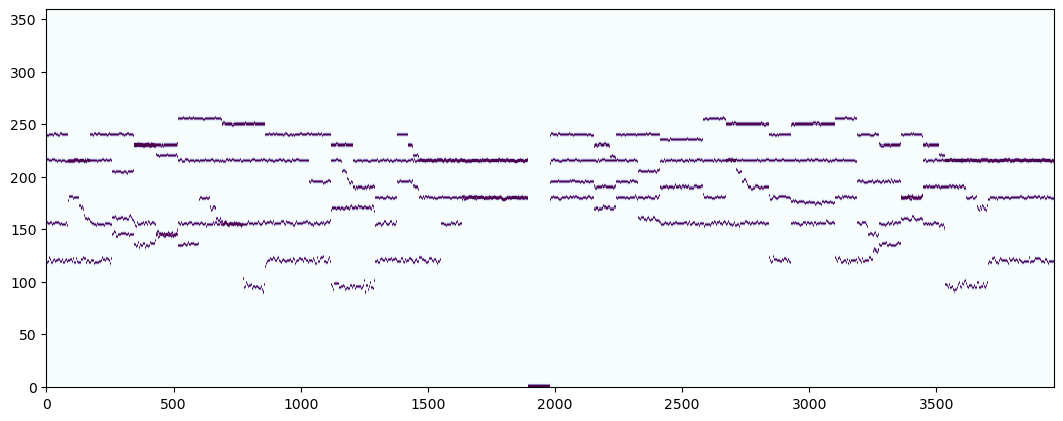

In [25]:
sscs_plot_random('mix')

## 6 - Getting data splits for training

In [26]:
input, outputs = sscs_get_data(SPLIT_SIZE, amount=15)
print(input.shape)

(1932, 360, 128)


## 7- Training VoasCNN

In [27]:
class VoasCrossentropy(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        log_y_pred = tf.math.log(y_pred)
        log_y_pred_comp = tf.math.log(1 - y_pred)
        aux1 = -tf.math.multiply_no_nan(x=log_y_pred, y=y_true)
        aux2 = -tf.math.multiply_no_nan(x=log_y_pred_comp, y=(1 - y_true))
        elements = aux1 + aux2
        return tf.reduce_mean(tf.reduce_sum(elements, range(tf.rank(y_pred))))

In [28]:
voas_cnn = voas_cnn_model()
voas_cnn.compile(optimizer=Adam(learning_rate=1e-3),
                 loss=VoasCrossentropy(),
                 metrics=[Precision()])
#voas_cnn.summary()
voas_cnn.fit(input, outputs, batch_size=32, epochs=10)

Epoch 1/10
61/61 [==============================] - 427s 7s/step - loss: 712939.5000 - tf.compat.v1.squeeze_loss: 227008.1094 - tf.compat.v1.squeeze_1_loss: 170484.6719 - tf.compat.v1.squeeze_2_loss: 149554.9531 - tf.compat.v1.squeeze_3_loss: 165891.8750 - tf.compat.v1.squeeze_precision: 0.0173 - tf.compat.v1.squeeze_1_precision: 0.0549 - tf.compat.v1.squeeze_2_precision: 0.0451 - tf.compat.v1.squeeze_3_precision: 0.0309
Epoch 2/10
61/61 [==============================] - 414s 7s/step - loss: 99794.9922 - tf.compat.v1.squeeze_loss: 22073.2910 - tf.compat.v1.squeeze_1_loss: 28935.7090 - tf.compat.v1.squeeze_2_loss: 26590.2051 - tf.compat.v1.squeeze_3_loss: 22195.7520 - tf.compat.v1.squeeze_precision: 0.8386 - tf.compat.v1.squeeze_1_precision: 0.8647 - tf.compat.v1.squeeze_2_precision: 0.8061 - tf.compat.v1.squeeze_3_precision: 0.8434
Epoch 3/10
61/61 [==============================] - 418s 7s/step - loss: 83209.7812 - tf.compat.v1.squeeze_loss: 17817.2422 - tf.compat.v1.squeeze_1_loss: 

In [29]:
voas_cnn.fit(input, outputs, batch_size=32, epochs=5)

Epoch 1/5
61/61 [==============================] - 439s 7s/step - loss: 68529.3203 - tf.compat.v1.squeeze_loss: 14374.6582 - tf.compat.v1.squeeze_1_loss: 19830.6602 - tf.compat.v1.squeeze_2_loss: 19608.3262 - tf.compat.v1.squeeze_3_loss: 14715.6787 - tf.compat.v1.squeeze_precision: 0.8446 - tf.compat.v1.squeeze_1_precision: 0.8425 - tf.compat.v1.squeeze_2_precision: 0.8391 - tf.compat.v1.squeeze_3_precision: 0.8570
Epoch 2/5
61/61 [==============================] - 417s 7s/step - loss: 67436.1016 - tf.compat.v1.squeeze_loss: 14222.3271 - tf.compat.v1.squeeze_1_loss: 19374.3984 - tf.compat.v1.squeeze_2_loss: 19201.5664 - tf.compat.v1.squeeze_3_loss: 14637.8203 - tf.compat.v1.squeeze_precision: 0.8515 - tf.compat.v1.squeeze_1_precision: 0.8528 - tf.compat.v1.squeeze_2_precision: 0.8509 - tf.compat.v1.squeeze_3_precision: 0.8607
Epoch 3/5
61/61 [==============================] - 427s 7s/step - loss: 67535.2188 - tf.compat.v1.squeeze_loss: 14133.1543 - tf.compat.v1.squeeze_1_loss: 19393.97

In [75]:
rand_song = sscs_pick_random_song()
mix_real = ray.get(sscs_read_voice.remote(rand_song, 'mix'))
mix, s, a, t, b = ray.get(sscs_read_all_voice_splits.remote(rand_song, SPLIT_SIZE))

s_pred, a_pred, t_pred, b_pred = voas_cnn.predict(mix)

3/3 [==============================] - 10s 3s/step


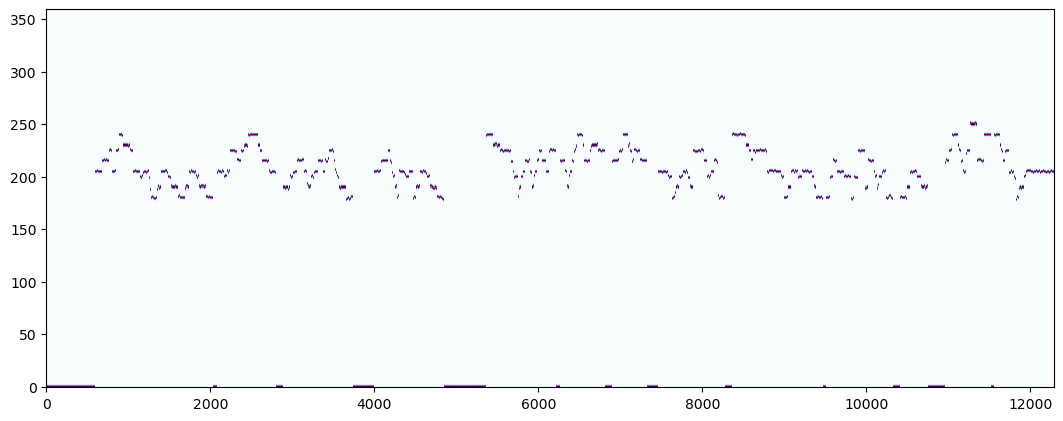

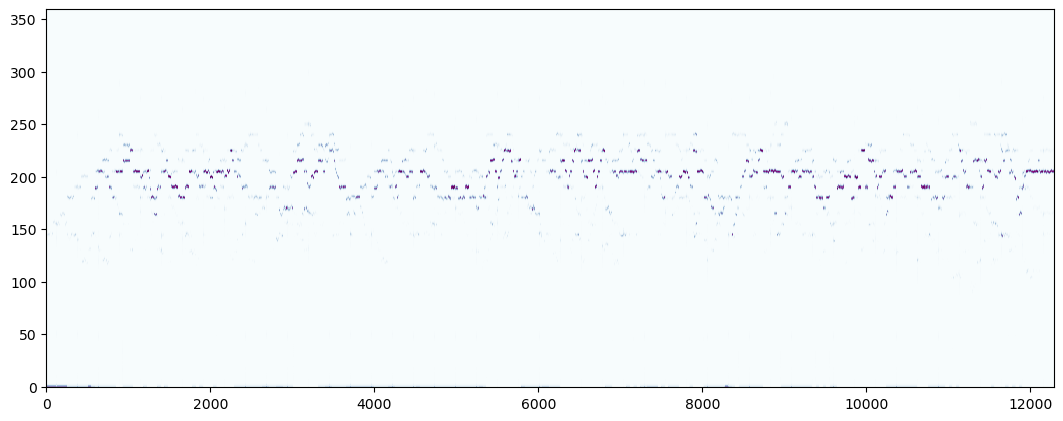

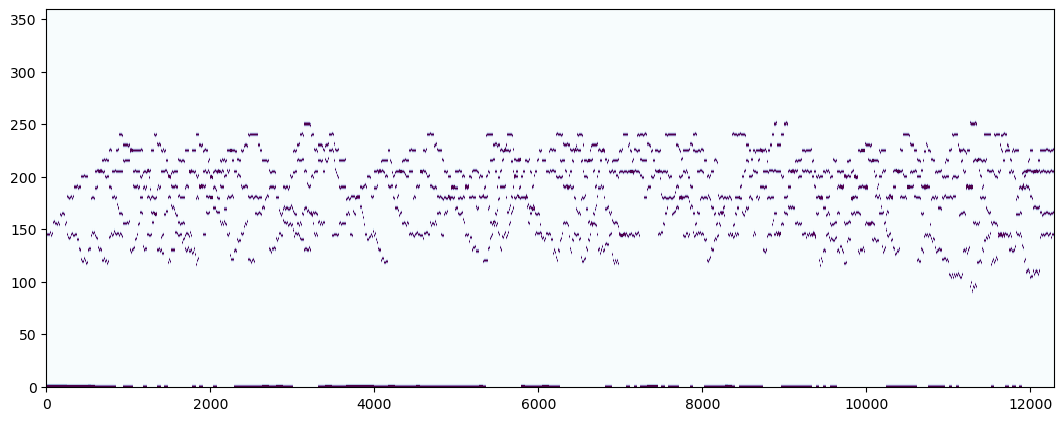

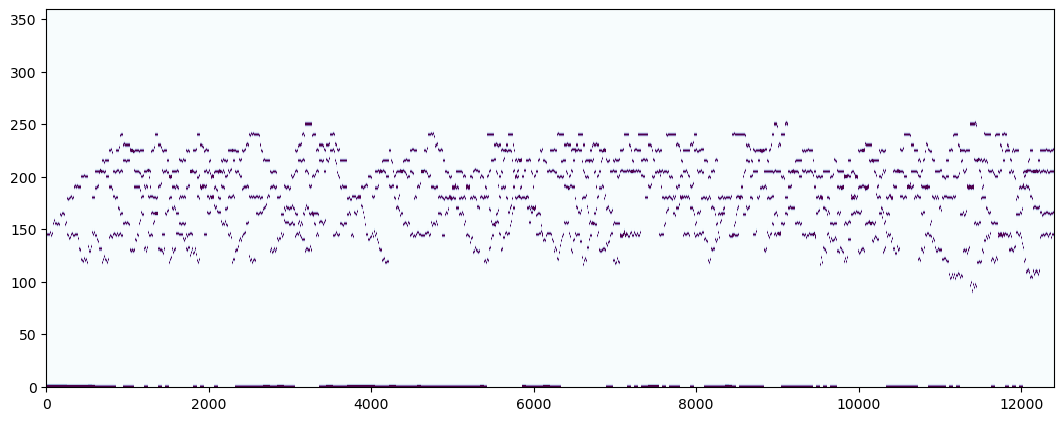

In [88]:
idx = 10
a_resh = np.moveaxis(a, 0, 1)
a_resh = np.reshape(a_resh, (360, -1))
a_pred_resh = np.moveaxis(a_pred, 0, 1)
a_pred_resh = np.reshape(a_pred_resh, (360, -1))
mix_resh = np.moveaxis(mix, 0, 1)
mix_resh = np.reshape(mix_resh, (360, -1))

sscs_plot(a_resh)
sscs_plot(a_pred_resh)
sscs_plot(mix_resh)
sscs_plot(mix_real)

